# Fairness Checking: Equalized Odds Constraint Experiment
This notebook uses PuLP to solve the linear program outlined in the "Fairness Checking" document. Here, **we experiment with varying the upper bound constraint on w and see its effects on the objective value.**

In [1]:
!pip install pulp

In [2]:
import pandas as pd
import numpy as np
import pulp
import matplotlib.pyplot as plt

In [3]:
# Run this cell to mount your Google Drive.
# from google.colab import drive
# drive.mount('/content/drive')

## Import Predicted Data
We take A (the protected attribute) to be the 'race' variable, and a = 0 while a' = 1. The last column, 'prediction,' is our f(X) variable, which can either be 0 or 1.

In [4]:
pred_df = pd.read_csv('./../predicted_data_new/fair_logreg_COMPAS.csv')

In [5]:
pred_df.head(5)

,Unnamed: 0,sex,race,age_cat=25 to 45,age_cat=Greater than 45,age_cat=Less than 25,priors_count=0,priors_count=1 to 3,priors_count=More than 3,c_charge_degree=F,c_charge_degree=M,two_year_recid,predictions
0,7960,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,7762,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,6466,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,9759,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,7130,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0


In [6]:
len(pred_df)

792

In [7]:
# Our protected variable A is race, and a = 0 or a = 1. 
a = pred_df['race']
np.asarray(a)
a_0_indices = []
a_1_indices = []

for i in range(len(a)):
    if a[i] == 0:
        a_0_indices.append(i)
    elif a[i] == 1:
        a_1_indices.append(i)

In [8]:
# Our true label Y is risk_recid, and y = 0 or y = 1. 
y = pred_df['two_year_recid']
np.asarray(y)
y_0_indices = []
y_1_indices = []

for i in range(len(y)):
    if y[i] == 0:
        y_0_indices.append(i)
    elif y[i] == 1:
        y_1_indices.append(i)

In [9]:
# Find the intersection of indices lists to make the pi's
a_0 = set(a_0_indices)
a_1 = set(a_1_indices)
y_0 = set(y_0_indices)
y_1 = set(y_1_indices)

a0_y0 = a_0.intersection(y_0) 
a0_y1 = a_0.intersection(y_1)
a1_y0 = a_1.intersection(y_0)
a1_y1 = a_1.intersection(y_1)

In [10]:
# Sanity check
print(len(y_0))
print(len(a1_y0) + len(a0_y0))
print(len(y_1))
print(len(a0_y1) + len(a1_y1))

393
393
399
399


In [11]:
# Our pi variables, pi_a_y are simply the proportions where we have A = a, Y = y
pi_0_0 = float(len(a0_y0))/(len(pred_df))
pi_0_1 = float(len(a0_y1))/(len(pred_df))
pi_1_0 = float(len(a1_y0))/(len(pred_df))
pi_1_1 = float(len(a1_y1))/(len(pred_df))

In [12]:
print(pi_0_0)
print(pi_0_1)
print(pi_1_0)
print(pi_1_1)
assert(pi_0_0 + pi_0_1 + pi_1_0 + pi_1_1 == 1.0)

0.2537878787878788
0.3434343434343434
0.24242424242424243
0.16035353535353536


In [13]:
# Our prediction probability is under 'prediction_probs.'
f_X = pred_df['predictions']
np.asarray(f_X)
print(len(f_X))

792


In [14]:
# Check if the dimensions match
print(len(f_X))
print(len(a0_y1) + len(a0_y0) + len(a1_y1) + len(a1_y0))

792
792


## Linear Program Function
Create a reusable function for each linear program.

The argument constraint is the constraint we want to set on the w's. This should be between 0 and 1.

The argument y_value should be Y = 0 or Y = 1, depending on which Y value we want to test EO on. 

In [15]:
# Input: function f(X), constraint, y_value (either 0 or 1)
# Output: (solved) model, weights
def EO_linear_prog(f_X, lower_bound, upper_bound, y_value):
  # Make sure constraint is within bounds
  assert(0 < lower_bound < 1)
  assert(0 < upper_bound < 1)

  if(y_value != 0 and y_value != 1):
    return("Please enter 0 or 1 for the second argument (y_value).")
  
  # Define the linear program as a maximization problem
  model = pulp.LpProblem("Equalized Odds Fairness Checking", pulp.LpMaximize)
  
  # Our w variable in the objective
  # Lower bound constraint set here with lowBound=0 option
  w = pulp.LpVariable.dicts("w", (i for i in range(len(f_X))),lowBound=0, cat='Continuous')
  
  if(y_value == 0):
    # Objective Function
    model += pulp.lpSum(
      [(1./pi_0_0) * w[index] * f_X[index] for index in a0_y0] +
      [- (1./pi_1_0) * w[index] * f_X[index] for index in a1_y0])
    
    # Constraint that the \sum(w_i * 1{a = 0, y = 0}) = pi_0_0
    model += pulp.lpSum([w[index] for index in a0_y0]) == pi_0_0
    
    # Constraint that the \sum(w_i * 1{a = 0, y = 1}) = pi_0_1
    model += pulp.lpSum([w[index] for index in a1_y0]) == pi_1_0
    
  elif(y_value == 1):
    # Objective Function
    model += pulp.lpSum(
        [(1./pi_0_1) * w[index] * f_X[index] for index in a0_y1] +
        [- (1./pi_1_1) * w[index] * f_X[index] for index in a1_y1])
    
    # Constraint that the \sum(w_i * 1{a = 0, y = 1}) = pi_0_1
    model += pulp.lpSum([w[index] for index in a0_y1]) == pi_0_1
    
    # Constraint that the \sum(w_i * 1{a = 1, y = 1}) = pi_0_1
    model += pulp.lpSum([w[index] for index in a1_y1]) == pi_1_1
  
  # Constraint that the w's all sum to 1
  model += pulp.lpSum([w[i] for i in range(len(f_X))]) == 1

  # IMPORTANT: Constraint we set on the w's. Experiment with this
  for weight in w:
    model += w[weight] >= lower_bound
    model += w[weight] <= upper_bound
  
  # Solve the linear program
  model.solve()
  
  return model, w

# Get the results
def weights_dictionary(w):
  results_dict = dict()
  for i in range(len(f_X)):
    results_dict[i] = w[i].varValue
  return results_dict

## Experiment with Linear Program (Y = 0)
Experiment with setting the constraints as: $$w_i \leq \frac{(1 + \epsilon)}{n}$$ and $$\frac{(1 - \epsilon)}{n} \leq w_i$$ where n is the number of samples in the data.

In [16]:
epsilon_granule = 0.01

lower_bounds = []
upper_bounds = []
y0_objective_values = []
dist_weights = []
epsilons = []

# Iterate over constraints
for i in range(0, 100):
  epsilon = epsilon_granule * i
  lower_bound = (1 - epsilon)/(len(f_X))
  upper_bound = (1 + epsilon)/(len(f_X))
  model, weights = EO_linear_prog(f_X, lower_bound, upper_bound, 0)
  y0_objective_values.append(pulp.value(model.objective))
  epsilons.append(epsilon)
  lower_bounds.append(lower_bound)
  upper_bounds.append(upper_bound)
  dist_weights.append(weights)

Text(0.5, 1.0, 'Upper Bound Constraint on w vs. EO LP Objective Value (Y = 0)')

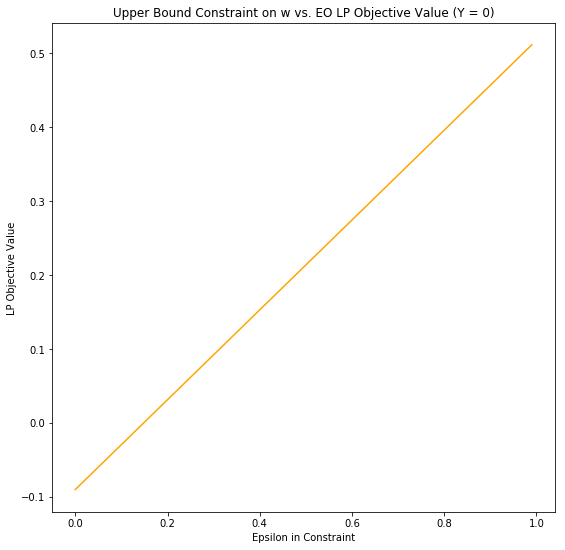

In [17]:
# Plot the constraints vs. objective values
plt.figure(figsize=(9,9))
plt.plot(epsilons, y0_objective_values, 'orange')
plt.xlabel('Epsilon in Constraint')
plt.ylabel('LP Objective Value')
plt.title('Upper Bound Constraint on w vs. EO LP Objective Value (Y = 0)')

In [18]:
print(len(dist_weights))
print(len(epsilons))

epsilon_to_weights = dict()
for i in range(len(epsilons)):
    epsilon_to_weights[epsilons[i]] = weights_dictionary(dist_weights[i])

100
100


In [19]:
print(len(pred_df))
print(len(epsilon_to_weights[0.01]))

792
792


In [20]:
# when weights = 0
print(epsilons[0])
print(y0_objective_values[0])

0.0
-0.0902518683430969


## Marginal Distributions (Y = 0)

In [21]:
from collections import defaultdict

# Create a dictionary for our table at the end
table_results = defaultdict(list)

In [22]:
# Find the accuracy of our classifier
tp = len(pred_df[(pred_df['predictions'] == 0) & (pred_df['two_year_recid'] == 0)])
tn = len(pred_df[(pred_df['predictions'] == 1) & (pred_df['two_year_recid'] == 1)])
acc = float(tp + tn)/len(pred_df)

In [23]:
# Find the lowest epsilon value that has a greater than 10% violation
for i in range(len(epsilons)):
    if(y0_objective_values[i] > 0.1):
        lowest_i = i
        break

print(y0_objective_values[lowest_i])
print(epsilons[lowest_i])
table_results['epsilon'].append(epsilons[lowest_i])
table_results['initial_unfairness'].append(y0_objective_values[0])
table_results['acc'].append(acc)

0.10420087708578346
0.32


In [24]:
pred_df['weights'] = epsilon_to_weights[epsilons[lowest_i]].values() # For example, when epsilon = 0.01
pred_df.head(5)

,Unnamed: 0,sex,race,age_cat=25 to 45,age_cat=Greater than 45,age_cat=Less than 25,priors_count=0,priors_count=1 to 3,priors_count=More than 3,c_charge_degree=F,c_charge_degree=M,two_year_recid,predictions,weights
0,7960,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.001667
1,7762,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.001667
2,6466,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.001667
3,9759,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.001667
4,7130,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.001667


In [25]:
# Marginal Distribution Function
def marginalize(data, X_attr, weights):
    X_values = data[X_attr]
    key_list = np.unique(X_values)
    X_marginal = {k: 0 for k in key_list}
    for i in range(0, len(X_values)):
        X_marginal[X_values[i]] = X_marginal[X_values[i]] + weights[i]
    return X_marginal

def freq_dict(data, X_attr):
    X_values = data[X_attr].value_counts()
    X_freqs = dict()
    for value in X_values.keys():
        X_freqs[value] = float(X_values[value])/float(len(data))
    return X_freqs

# Returns a tuple of two lists of the items in each dictionary sorted by order of their keys
def graph_tuple(dict1, dict2):
    tuple1 = []
    tuple2 = []
    for key in sorted(dict1.keys()):
        tuple1.append(dict1[key])
        tuple2.append(dict2[key])
    
    return (tuple1, tuple2)

In [26]:
def l1_dist(dict1, dict2):
    l1_total = 0
    for key in sorted(dict1.keys()):
        diff = abs(dict1[key] - dict2[key])
        l1_total = l1_total + diff
        
    return l1_total

In [27]:
# Get the unweighted and weighted distributions on the data
X_sex_freq = freq_dict(pred_df, 'sex')
X_sex_marginal = marginalize(pred_df, 'sex', pred_df['weights'])

print(X_sex_freq)
print(X_sex_marginal)

X_sex_tuple = graph_tuple(X_sex_freq, X_sex_marginal)

{0.0: 0.821969696969697, 1.0: 0.17803030303030304}
{0.0: 0.8199495062199974, 1.0: 0.18005050758000055}


In [28]:
table_results['sex'].append(l1_dist(X_sex_freq, X_sex_marginal))

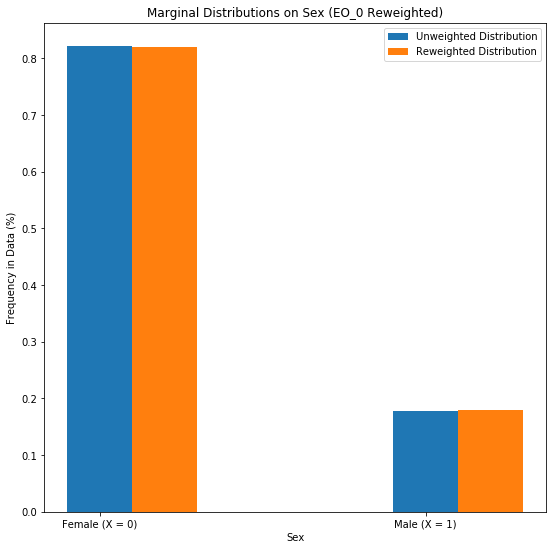

In [29]:
# Marginal Distribution on Sex 

X = np.arange(len(X_sex_freq))
plt.figure(figsize=(9,9))
plt.title('Marginal Distributions on Sex (EO_0 Reweighted)')
plt.bar(X, X_sex_tuple[0], width=0.2, align='center')
plt.bar(X+0.2, X_sex_tuple[1], width=0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Female (X = 0)', 'Male (X = 1)'])
plt.xlabel('Sex')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [30]:
X_age_25_45_freq = freq_dict(pred_df, 'age_cat=25 to 45')
X_age_25_45_marginal = marginalize(pred_df, 'age_cat=25 to 45', pred_df['weights'])
X_age_25_45_tuple = graph_tuple(X_age_25_45_freq, X_age_25_45_marginal)

In [31]:
table_results['age_25_45'].append(l1_dist(X_age_25_45_freq, X_age_25_45_marginal))

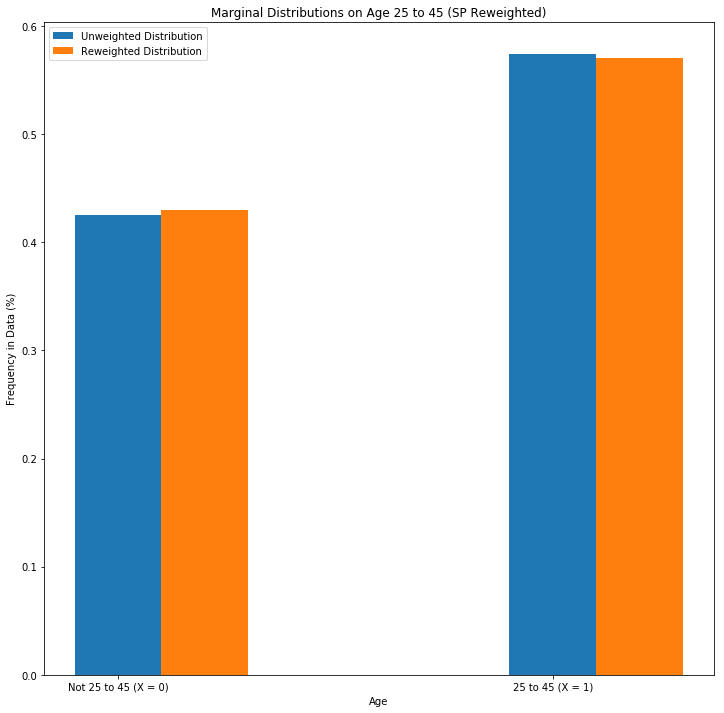

In [32]:
# Marginal Distribution on Age 
X = np.asarray(list(X_age_25_45_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Age 25 to 45 (SP Reweighted)')
plt.bar(X, X_age_25_45_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_25_45_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Not 25 to 45 (X = 0)', '25 to 45 (X = 1)'])
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [33]:
X_age_25_freq = freq_dict(pred_df, 'age_cat=Less than 25')
X_age_25_marginal = marginalize(pred_df, 'age_cat=Less than 25', pred_df['weights'])
X_age_25_tuple = graph_tuple(X_age_25_freq, X_age_25_marginal)

In [34]:
table_results['age_25'].append(l1_dist(X_age_25_freq, X_age_25_marginal))

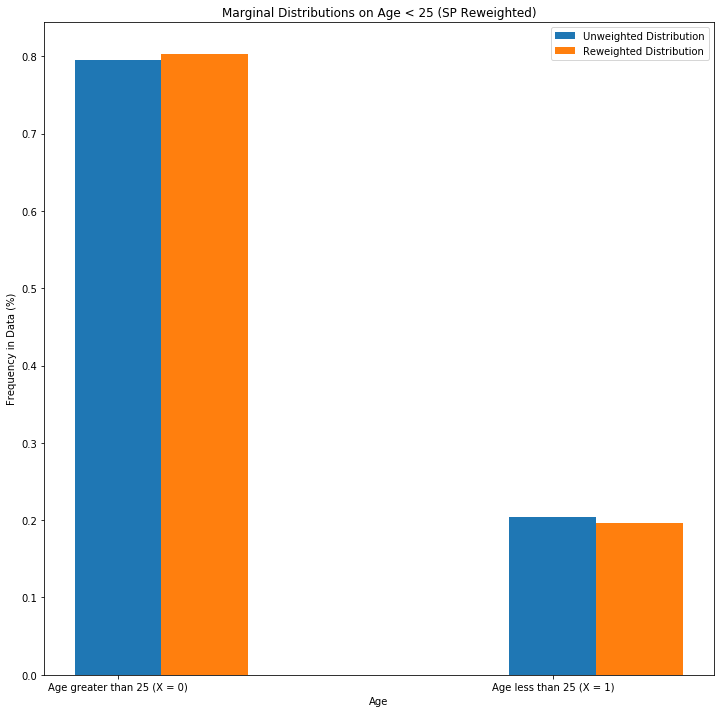

In [35]:
# Marginal Distribution on Age 
X = np.asarray(list(X_age_25_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Age < 25 (SP Reweighted)')
plt.bar(X, X_age_25_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_25_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Age greater than 25 (X = 0)', 'Age less than 25 (X = 1)'])
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [36]:
X_age_45_freq = freq_dict(pred_df, 'age_cat=Greater than 45')
X_age_45_marginal = marginalize(pred_df, 'age_cat=Greater than 45', pred_df['weights'])
X_age_45_tuple = graph_tuple(X_age_45_freq, X_age_45_marginal)

In [37]:
table_results['age_45'].append(l1_dist(X_age_45_freq, X_age_45_marginal))

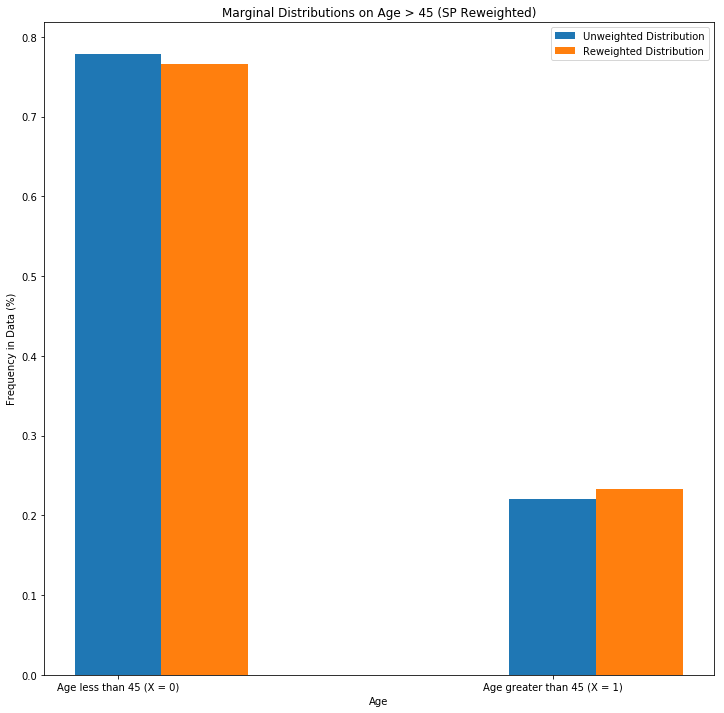

In [38]:
# Marginal Distribution on Age 
X = np.asarray(list(X_age_45_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Age > 45 (SP Reweighted)')
plt.bar(X, X_age_45_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_45_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Age less than 45 (X = 0)', 'Age greater than 45 (X = 1)'])
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [39]:
X_priors_freq = freq_dict(pred_df, 'priors_count=0')
X_priors_marginal = marginalize(pred_df, 'priors_count=0', pred_df['weights'])
X_priors_tuple = graph_tuple(X_priors_freq, X_priors_marginal)

In [40]:
table_results['priors_0'].append(l1_dist(X_priors_freq, X_priors_marginal))

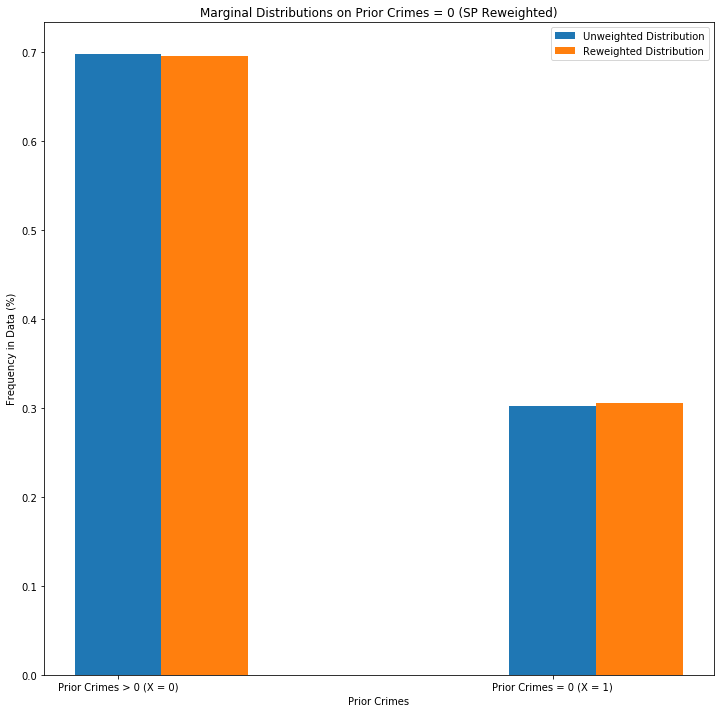

In [41]:
# Marginal Distribution on Priors 
X = np.asarray(list(X_priors_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Prior Crimes = 0 (SP Reweighted)')
plt.bar(X, X_priors_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_priors_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Prior Crimes > 0 (X = 0)', 'Prior Crimes = 0 (X = 1)'])
plt.xlabel('Prior Crimes')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [42]:
X_priors_freq = freq_dict(pred_df, 'priors_count=1 to 3')
X_priors_marginal = marginalize(pred_df, 'priors_count=1 to 3', pred_df['weights'])
X_priors_tuple = graph_tuple(X_priors_freq, X_priors_marginal)

In [43]:
table_results['priors_1_3'].append(l1_dist(X_priors_freq, X_priors_marginal))

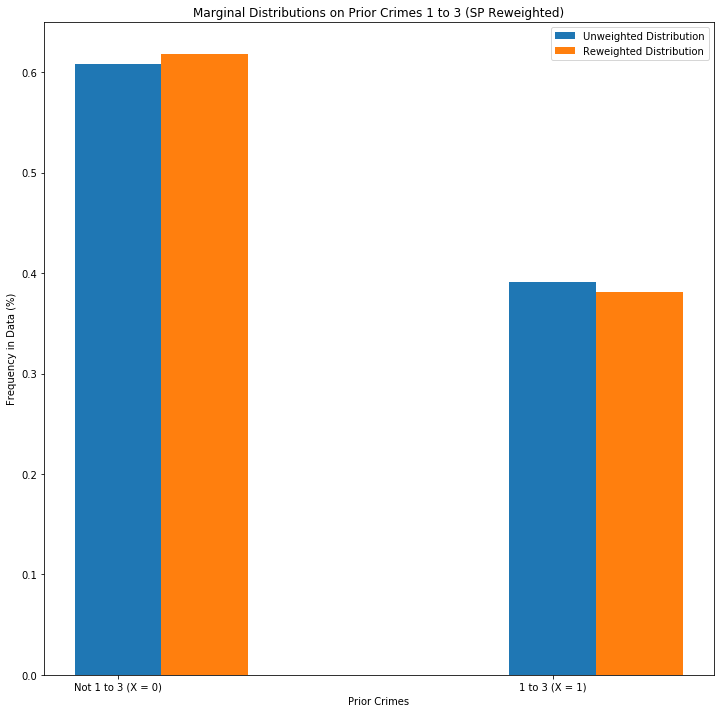

In [44]:
# Marginal Distribution on Priors 
X = np.asarray(list(X_priors_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Prior Crimes 1 to 3 (SP Reweighted)')
plt.bar(X, X_priors_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_priors_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Not 1 to 3 (X = 0)', '1 to 3 (X = 1)'])
plt.xlabel('Prior Crimes')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [45]:
X_priors_freq = freq_dict(pred_df, 'priors_count=More than 3')
X_priors_marginal = marginalize(pred_df, 'priors_count=More than 3', pred_df['weights'])
X_priors_tuple = graph_tuple(X_priors_freq, X_priors_marginal)

In [46]:
table_results['priors_3'].append(l1_dist(X_priors_freq, X_priors_marginal))

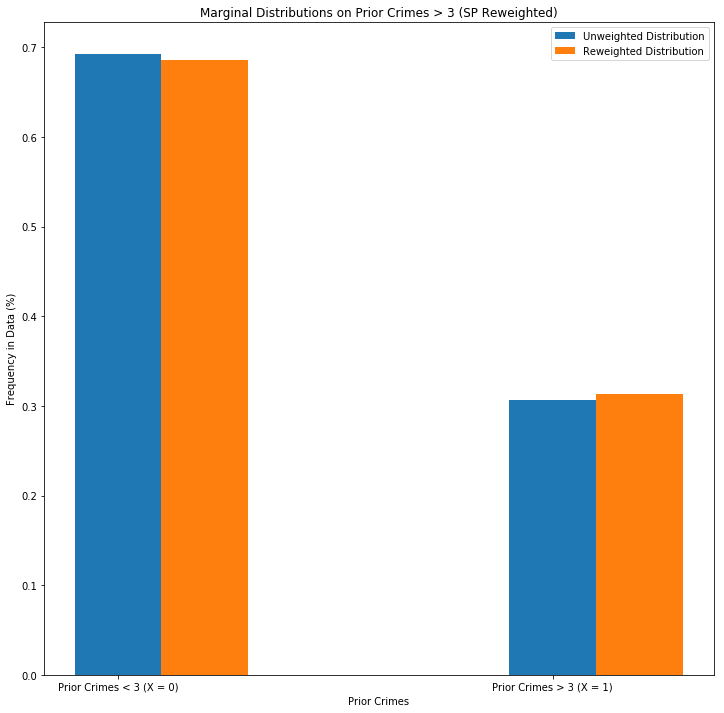

In [47]:
# Marginal Distribution on Priors 
X = np.asarray(list(X_priors_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Prior Crimes > 3 (SP Reweighted)')
plt.bar(X, X_priors_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_priors_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Prior Crimes < 3 (X = 0)', 'Prior Crimes > 3 (X = 1)'])
plt.xlabel('Prior Crimes')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [48]:
X_charge_deg_freq = freq_dict(pred_df, 'c_charge_degree=F')
X_charge_deg_marginal = marginalize(pred_df, 'c_charge_degree=F', pred_df['weights'])
X_charge_deg_tuple = graph_tuple(X_charge_deg_freq, X_charge_deg_marginal)

In [49]:
table_results['charge_deg_F'].append(l1_dist(X_charge_deg_freq, X_charge_deg_marginal))

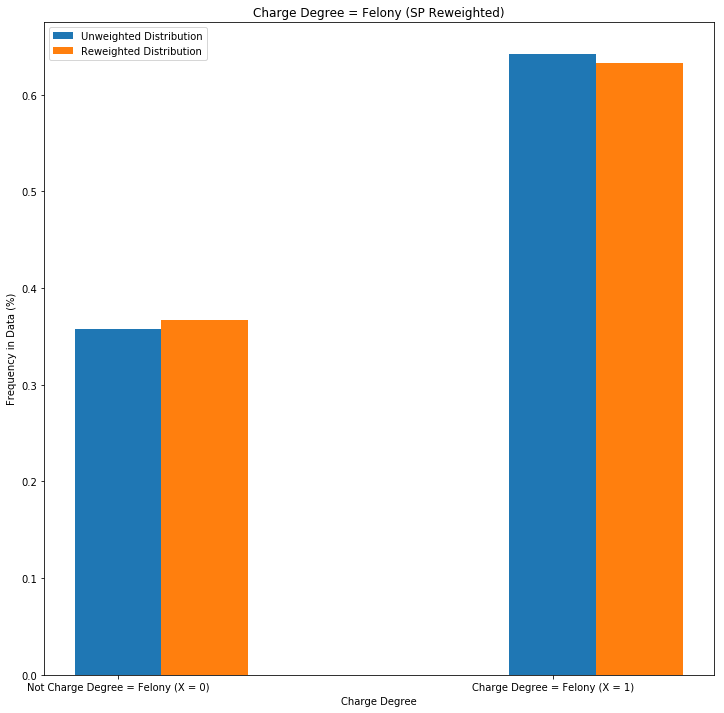

In [50]:
# Marginal Distribution on Charge Degree 
X = np.asarray(list(X_priors_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Charge Degree = Felony (SP Reweighted)')
plt.bar(X, X_charge_deg_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_charge_deg_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Not Charge Degree = Felony (X = 0)', 'Charge Degree = Felony (X = 1)'])
plt.xlabel('Charge Degree')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [51]:
X_charge_deg_freq = freq_dict(pred_df, 'c_charge_degree=M')
X_charge_deg_marginal = marginalize(pred_df, 'c_charge_degree=M', pred_df['weights'])
X_charge_deg_tuple = graph_tuple(X_charge_deg_freq, X_charge_deg_marginal)

In [52]:
table_results['charge_deg_M'].append(l1_dist(X_charge_deg_freq, X_charge_deg_marginal))

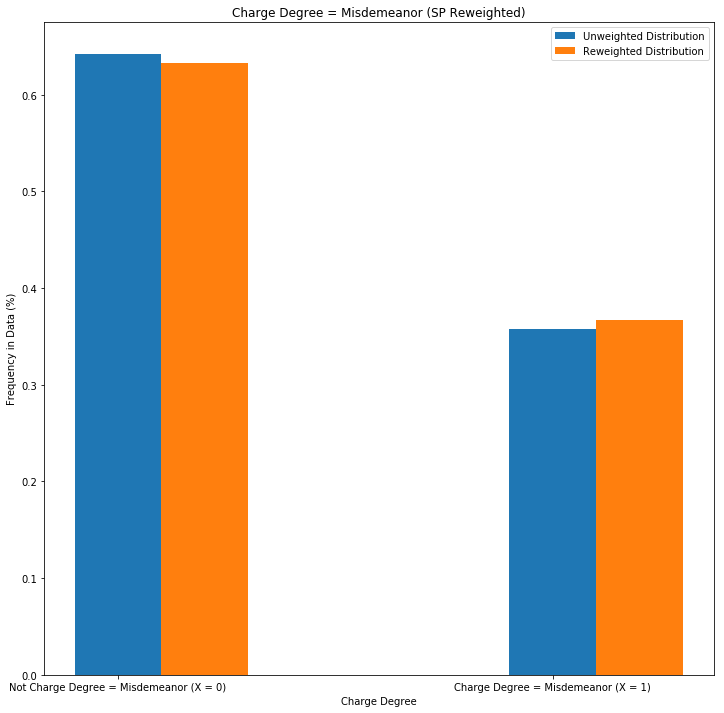

In [53]:
# Marginal Distribution on Charge Degree 
X = np.asarray(list(X_priors_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Charge Degree = Misdemeanor (SP Reweighted)')
plt.bar(X, X_charge_deg_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_charge_deg_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Not Charge Degree = Misdemeanor (X = 0)', 'Charge Degree = Misdemeanor (X = 1)'])
plt.xlabel('Charge Degree')
plt.ylabel('Frequency in Data (%)')
plt.show()

## Experiment with Linear Program (Y = 1)
Experiment with setting the constraints as: $$w_i \leq \frac{(1 + \epsilon)}{n}$$ and $$\frac{(1 - \epsilon)}{n} \leq w_i$$ where n is the number of samples in the data.

In [54]:
epsilon_granule = 0.01

lower_bounds = []
upper_bounds = []
y1_objective_values = []
dist_weights = []
epsilons = []

# Iterate over constraints
for i in range(0, 100):
  epsilon = epsilon_granule * i
  lower_bound = (1 - epsilon)/(len(f_X))
  upper_bound = (1 + epsilon)/(len(f_X))
  model, weights = EO_linear_prog(f_X, lower_bound, upper_bound, 1)
  y1_objective_values.append(pulp.value(model.objective))
  epsilons.append(epsilon)
  lower_bounds.append(lower_bound)
  upper_bounds.append(upper_bound)
  dist_weights.append(weights)

Text(0.5, 1.0, 'Upper Bound Constraint on w vs. EO LP Objective Value (Y = 1)')

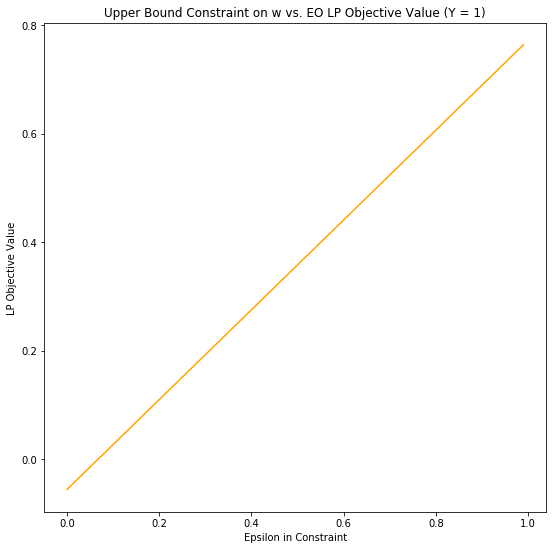

In [55]:
# Plot the constraints vs. objective values
plt.figure(figsize=(9,9))
plt.plot(epsilons, y1_objective_values, 'orange')
plt.xlabel('Epsilon in Constraint')
plt.ylabel('LP Objective Value')
plt.title('Upper Bound Constraint on w vs. EO LP Objective Value (Y = 1)')

In [56]:
print(len(dist_weights))
print(len(epsilons))

epsilon_to_weights = dict()
for i in range(len(epsilons)):
    epsilon_to_weights[epsilons[i]] = weights_dictionary(dist_weights[i])

100
100


In [57]:
# when weights = 0
print(epsilons[0])
print(y1_objective_values[0])

0.0
-0.05534970057304312


## Marginal Distributions (Y = 1)

In [58]:
# Find the lowest epsilon value that has a greater than 10% violation
for i in range(len(epsilons)):
    if(y1_objective_values[i] > 0.1):
        lowest_i = i
        break

print(y1_objective_values[lowest_i])
print(epsilons[lowest_i])

table_results['epsilon'].append(epsilons[lowest_i])
table_results['initial_unfairness'].append(y1_objective_values[0])
table_results['acc'] = acc

0.10178092206892214
0.19


In [59]:
pred_df['weights'] = epsilon_to_weights[epsilons[lowest_i]].values() # For example, when epsilon = 0.01
pred_df.head(5)

,Unnamed: 0,sex,race,age_cat=25 to 45,age_cat=Greater than 45,age_cat=Less than 25,priors_count=0,priors_count=1 to 3,priors_count=More than 3,c_charge_degree=F,c_charge_degree=M,two_year_recid,predictions,weights
0,7960,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.001503
1,7762,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.001503
2,6466,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.001503
3,9759,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.001503
4,7130,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.001023


In [60]:
# Marginal Distribution Function
def marginalize(data, X_attr, weights):
    X_values = data[X_attr]
    key_list = np.unique(X_values)
    X_marginal = {k: 0 for k in key_list}
    for i in range(0, len(X_values)):
        X_marginal[X_values[i]] = X_marginal[X_values[i]] + weights[i]
    return X_marginal

def freq_dict(data, X_attr):
    X_values = data[X_attr].value_counts()
    X_freqs = dict()
    for value in X_values.keys():
        X_freqs[value] = float(X_values[value])/float(len(data))
    return X_freqs

# Returns a tuple of two lists of the items in each dictionary sorted by order of their keys
def graph_tuple(dict1, dict2):
    tuple1 = []
    tuple2 = []
    for key in sorted(dict1.keys()):
        tuple1.append(dict1[key])
        tuple2.append(dict2[key])
    
    return (tuple1, tuple2)

In [61]:
# Get the unweighted and weighted distributions on the data
X_sex_freq = freq_dict(pred_df, 'sex')
X_sex_marginal = marginalize(pred_df, 'sex', pred_df['weights'])

print(X_sex_freq)
print(X_sex_marginal)

X_sex_tuple = graph_tuple(X_sex_freq, X_sex_marginal)

{0.0: 0.821969696969697, 1.0: 0.17803030303030304}
{0.0: 0.8250884082999914, 1.0: 0.1749116213}


In [62]:
table_results['sex'].append(l1_dist(X_sex_freq, X_sex_marginal))

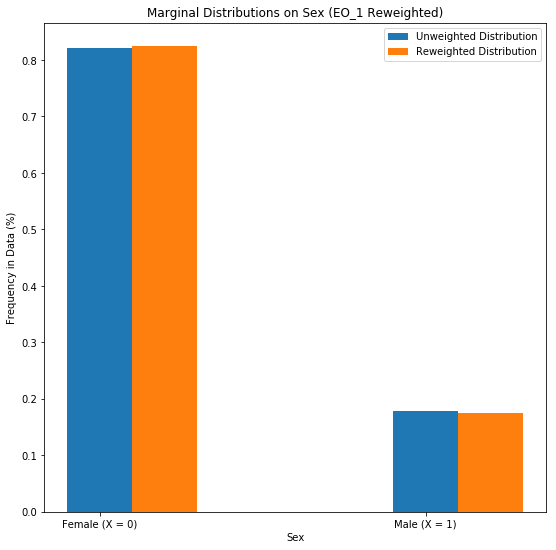

In [63]:
# Marginal Distribution on Sex 

X = np.arange(len(X_sex_freq))
plt.figure(figsize=(9,9))
plt.title('Marginal Distributions on Sex (EO_1 Reweighted)')
plt.bar(X, X_sex_tuple[0], width=0.2, align='center')
plt.bar(X+0.2, X_sex_tuple[1], width=0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Female (X = 0)', 'Male (X = 1)'])
plt.xlabel('Sex')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [64]:
X_age_25_45_freq = freq_dict(pred_df, 'age_cat=25 to 45')
X_age_25_45_marginal = marginalize(pred_df, 'age_cat=25 to 45', pred_df['weights'])
X_age_25_45_tuple = graph_tuple(X_age_25_45_freq, X_age_25_45_marginal)

In [65]:
table_results['age_25_45'].append(l1_dist(X_age_25_45_freq, X_age_25_45_marginal))

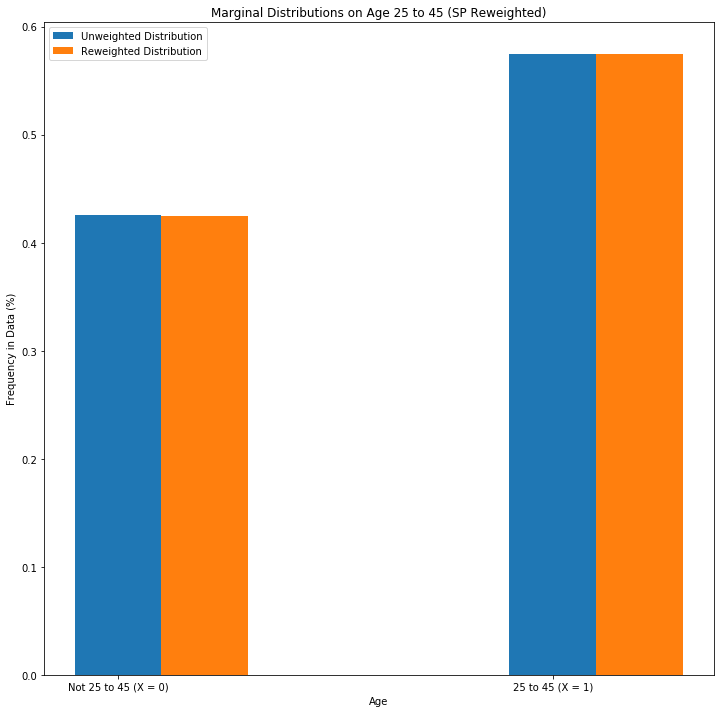

In [66]:
# Marginal Distribution on Age 
X = np.asarray(list(X_age_25_45_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Age 25 to 45 (SP Reweighted)')
plt.bar(X, X_age_25_45_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_25_45_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Not 25 to 45 (X = 0)', '25 to 45 (X = 1)'])
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [67]:
X_age_25_freq = freq_dict(pred_df, 'age_cat=Less than 25')
X_age_25_marginal = marginalize(pred_df, 'age_cat=Less than 25', pred_df['weights'])
X_age_25_tuple = graph_tuple(X_age_25_freq, X_age_25_marginal)

In [68]:
table_results['age_25'].append(l1_dist(X_age_25_freq, X_age_25_marginal))

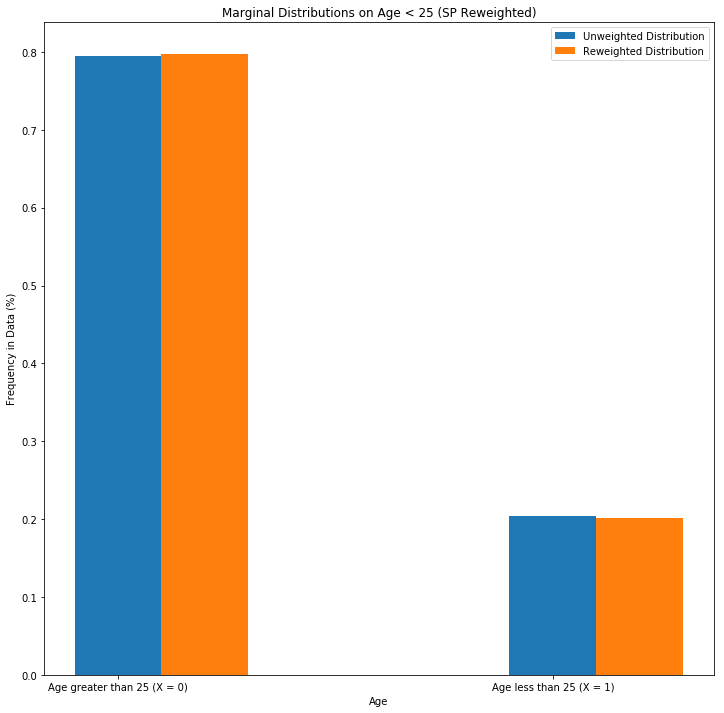

In [69]:
# Marginal Distribution on Age 
X = np.asarray(list(X_age_25_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Age < 25 (SP Reweighted)')
plt.bar(X, X_age_25_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_25_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Age greater than 25 (X = 0)', 'Age less than 25 (X = 1)'])
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [70]:
X_age_45_freq = freq_dict(pred_df, 'age_cat=Greater than 45')
X_age_45_marginal = marginalize(pred_df, 'age_cat=Greater than 45', pred_df['weights'])
X_age_45_tuple = graph_tuple(X_age_45_freq, X_age_45_marginal)

In [71]:
table_results['age_45'].append(l1_dist(X_age_45_freq, X_age_45_marginal))

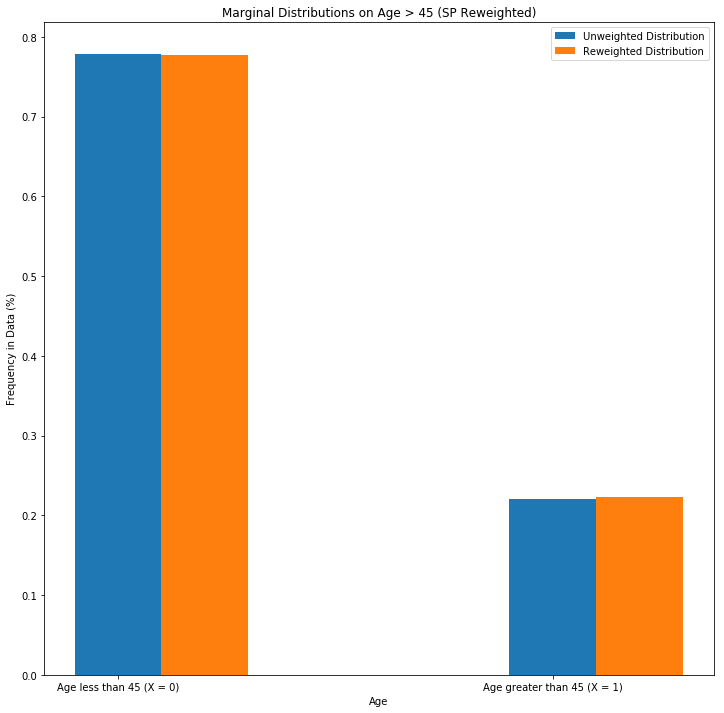

In [72]:
# Marginal Distribution on Age 
X = np.asarray(list(X_age_45_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Age > 45 (SP Reweighted)')
plt.bar(X, X_age_45_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_45_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Age less than 45 (X = 0)', 'Age greater than 45 (X = 1)'])
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [73]:
X_priors_freq = freq_dict(pred_df, 'priors_count=0')
X_priors_marginal = marginalize(pred_df, 'priors_count=0', pred_df['weights'])
X_priors_tuple = graph_tuple(X_priors_freq, X_priors_marginal)

In [74]:
table_results['priors_0'].append(l1_dist(X_priors_freq, X_priors_marginal))

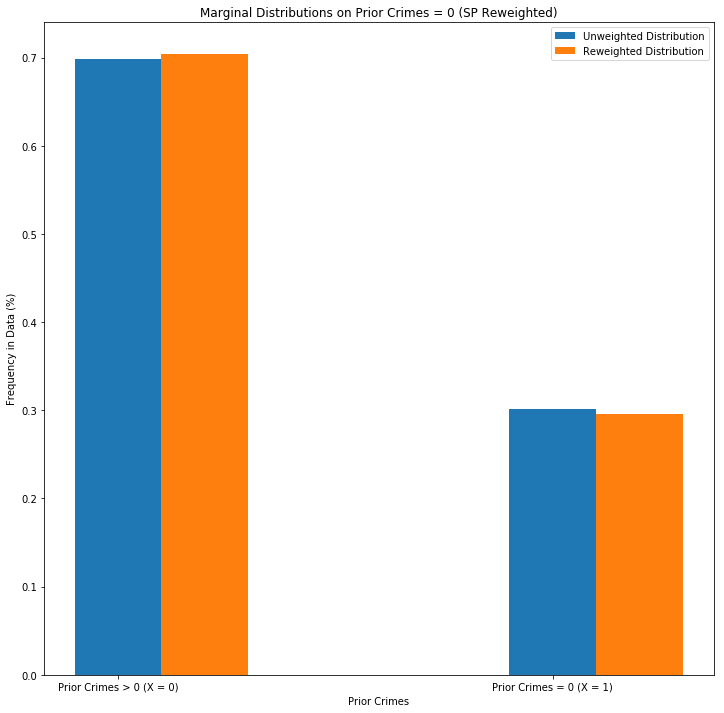

In [75]:
# Marginal Distribution on Priors 
X = np.asarray(list(X_priors_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Prior Crimes = 0 (SP Reweighted)')
plt.bar(X, X_priors_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_priors_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Prior Crimes > 0 (X = 0)', 'Prior Crimes = 0 (X = 1)'])
plt.xlabel('Prior Crimes')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [76]:
X_priors_freq = freq_dict(pred_df, 'priors_count=1 to 3')
X_priors_marginal = marginalize(pred_df, 'priors_count=1 to 3', pred_df['weights'])
X_priors_tuple = graph_tuple(X_priors_freq, X_priors_marginal)

In [77]:
table_results['priors_1_3'].append(l1_dist(X_priors_freq, X_priors_marginal))

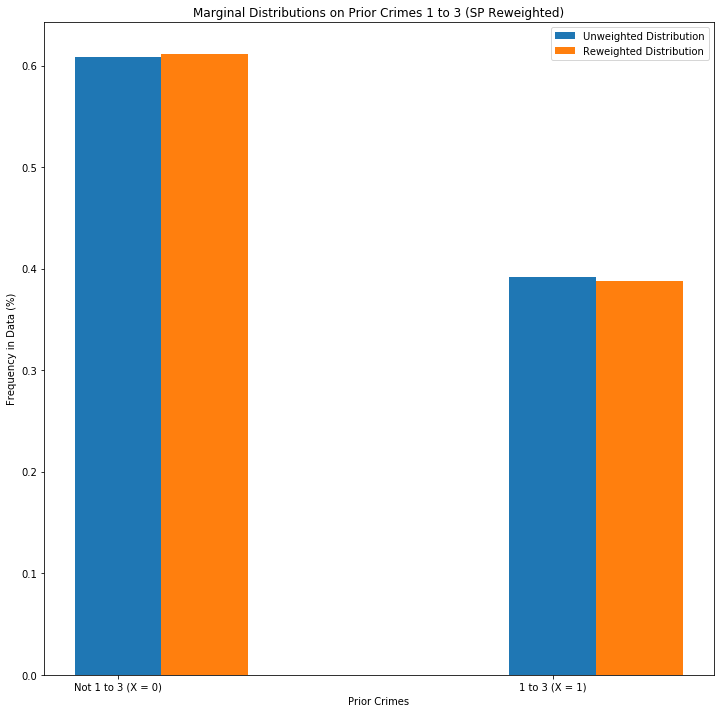

In [78]:
# Marginal Distribution on Priors 
X = np.asarray(list(X_priors_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Prior Crimes 1 to 3 (SP Reweighted)')
plt.bar(X, X_priors_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_priors_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Not 1 to 3 (X = 0)', '1 to 3 (X = 1)'])
plt.xlabel('Prior Crimes')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [79]:
X_priors_freq = freq_dict(pred_df, 'priors_count=More than 3')
X_priors_marginal = marginalize(pred_df, 'priors_count=More than 3', pred_df['weights'])
X_priors_tuple = graph_tuple(X_priors_freq, X_priors_marginal)

In [80]:
table_results['priors_3'].append(l1_dist(X_priors_freq, X_priors_marginal))

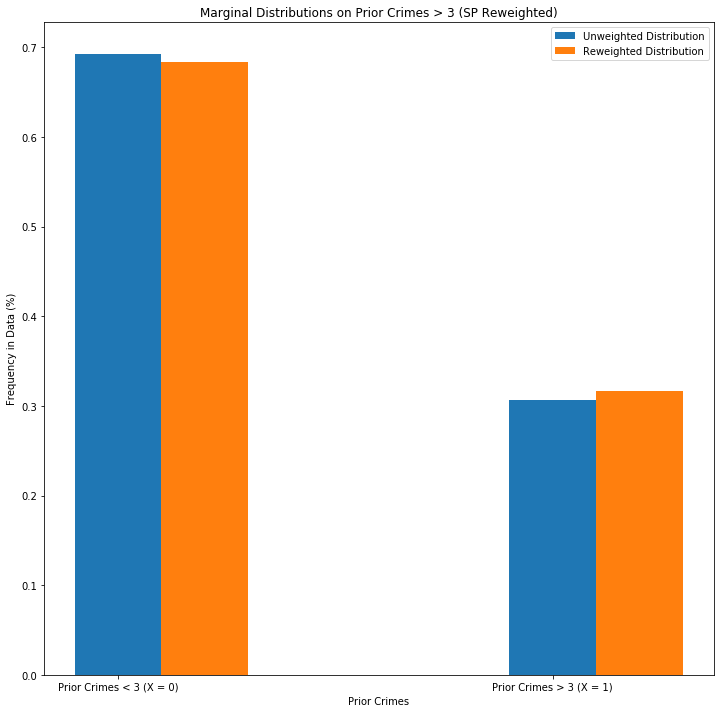

In [81]:
# Marginal Distribution on Priors 
X = np.asarray(list(X_priors_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Prior Crimes > 3 (SP Reweighted)')
plt.bar(X, X_priors_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_priors_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Prior Crimes < 3 (X = 0)', 'Prior Crimes > 3 (X = 1)'])
plt.xlabel('Prior Crimes')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [82]:
X_charge_deg_freq = freq_dict(pred_df, 'c_charge_degree=F')
X_charge_deg_marginal = marginalize(pred_df, 'c_charge_degree=F', pred_df['weights'])
X_charge_deg_tuple = graph_tuple(X_charge_deg_freq, X_charge_deg_marginal)

In [83]:
table_results['charge_deg_F'].append(l1_dist(X_charge_deg_freq, X_charge_deg_marginal))

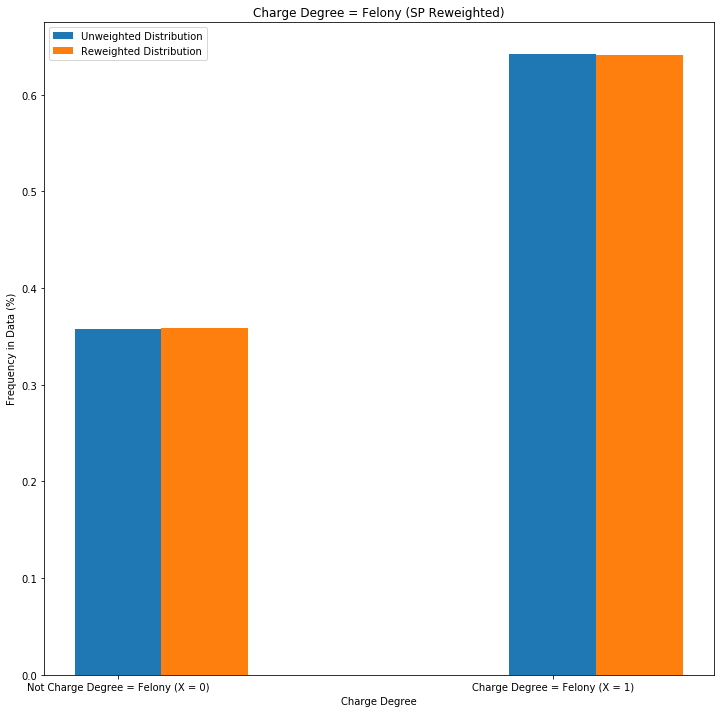

In [84]:
# Marginal Distribution on Charge Degree 
X = np.asarray(list(X_priors_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Charge Degree = Felony (SP Reweighted)')
plt.bar(X, X_charge_deg_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_charge_deg_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Not Charge Degree = Felony (X = 0)', 'Charge Degree = Felony (X = 1)'])
plt.xlabel('Charge Degree')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [85]:
X_charge_deg_freq = freq_dict(pred_df, 'c_charge_degree=M')
X_charge_deg_marginal = marginalize(pred_df, 'c_charge_degree=M', pred_df['weights'])
X_charge_deg_tuple = graph_tuple(X_charge_deg_freq, X_charge_deg_marginal)

In [86]:
table_results['charge_deg_M'].append(l1_dist(X_charge_deg_freq, X_charge_deg_marginal))

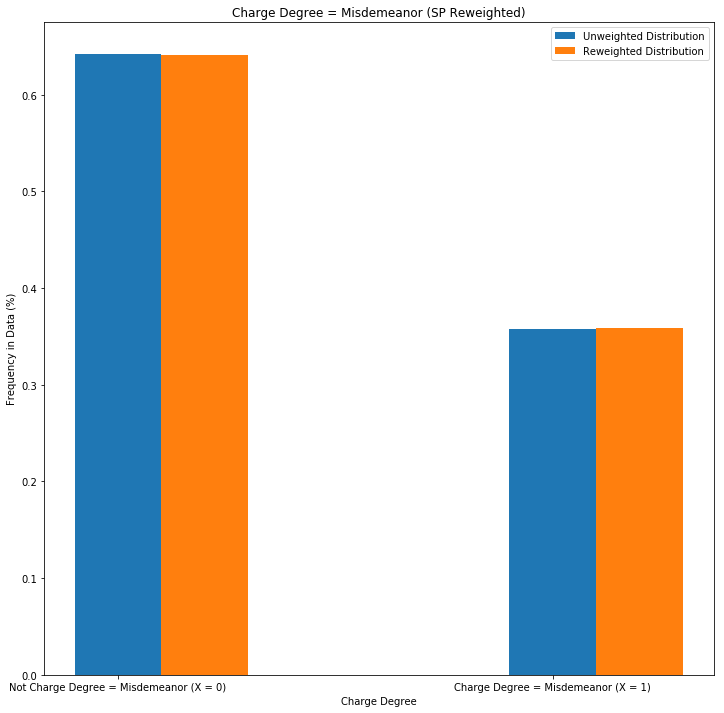

In [87]:
# Marginal Distribution on Charge Degree 
X = np.asarray(list(X_priors_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Charge Degree = Misdemeanor (SP Reweighted)')
plt.bar(X, X_charge_deg_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_charge_deg_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Not Charge Degree = Misdemeanor (X = 0)', 'Charge Degree = Misdemeanor (X = 1)'])
plt.xlabel('Charge Degree')
plt.ylabel('Frequency in Data (%)')
plt.show()

## Table Results

In [88]:
table_results.keys()

dict_keys(['epsilon', 'initial_unfairness', 'acc', 'sex', 'age_25_45', 'age_25', 'age_45', 'priors_0', 'priors_1_3', 'priors_3', 'charge_deg_F', 'charge_deg_M'])

In [89]:
table_results['initial_unfairness']

[-0.0902518683430969, -0.05534970057304312]

In [90]:
table_df = pd.DataFrame(table_results, index =['COMPAS_EO_Y0', 'COMPAS_EO_Y1'])

In [91]:
table_df

,epsilon,initial_unfairness,acc,sex,age_25_45,age_25,age_45,priors_0,priors_1_3,priors_3,charge_deg_F,charge_deg_M
COMPAS_EO_Y0,0.32,-0.090252,0.636364,0.004040,0.008889,0.016162,0.025050,0.006465,0.020202,0.013737,0.018586,0.018586
COMPAS_EO_Y1,0.19,-0.055350,0.636364,0.006237,0.001439,0.005278,0.003838,0.012955,0.006717,0.019672,0.003838,0.003838


In [92]:
table_df.to_csv('./result_tables/COMPAS_EO.csv')